In [1]:
import glob
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from pathlib import Path
import pickle
import torch
from itertools import groupby
from quantizer import Quantizer
from lib.dataset_wrapper import Dataset

In [2]:
# Get path of quantizers we want to analyze
#quantizer_paths = list(Path("../out/quantizer/thomas").glob('*'))
quantizer_paths = list(Path("../out/quantizer/trash/thomas").glob('*'))
quantizer_paths.sort()
quantizer_paths = [p for p in quantizer_paths if '-' in p.name]

configs = pd.DataFrame()
for quantizer_path in quantizer_paths:
    quantizer = Quantizer.reload(str(quantizer_path))
    config = quantizer.config
    config = pd.json_normalize(config, sep='.').to_dict(orient='records')[0]
    config['dataset.data_types'] = '_'.join(config['dataset.data_types'])
    config['dataset.names'] = '_'.join(config['dataset.names'])
    config['quantizer_path'] = quantizer_path
    config = pd.DataFrame.from_dict(config, orient='index').transpose()
    if '_'.join(config['dataset.names']) not in ['pb2007', 'gb2016_th2016', 'fjmw0']:
        configs = pd.concat([configs,config])

configs.head()
print(len(configs))

/home/engaclew/miniconda3/envs/agent/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 1.3.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


90


In [3]:
# Only analyzing one model per speaker and per data type 
configs = configs[configs['dataset.datasplit_seed'] == 0]
configs.head()
quantizer_paths = configs['quantizer_path'].tolist()
print(len(quantizer_paths))
print(configs)

18
  dataset.batch_size   dataset.data_types dataset.datasplit_seed  \
0                  8  cepstrum_art_params                      0   
0                  8           art_params                      0   
0                  8             cepstrum                      0   
0                  8           art_params                      0   
0                  8  cepstrum_art_params                      0   
0                  8             cepstrum                      0   
0                  8           art_params                      0   
0                  8           art_params                      0   
0                  8           art_params                      0   
0                  8             cepstrum                      0   
0                  8  cepstrum_art_params                      0   
0                  8  cepstrum_art_params                      0   
0                  8             cepstrum                      0   
0                  8           art_params    

In [4]:
def get_mean_duration(quantizer_features):
    quantizer_features = [{k:np.argmax(v, axis=1)} for k,v in quantizer_features[main_dataset.name]['quantized_index'].items()]
    unit_durations = {}
    mean_dur = 0
    nb_units = 0
    for dict_feat in quantizer_features:
        for file, feat in dict_feat.items():
            durations = [len(list(v)) for k,v in groupby(feat)]
            mean_dur += np.sum(durations)
            nb_units += len(durations)
    unit_durations = {k:np.mean(v) for k,v in unit_durations.items()}
    mean_dur /= nb_units
    return mean_dur

quantizer_durations = {}
for quantizer_path in tqdm(quantizer_paths):
    # Get features of test set
    quantizer = Quantizer.reload(str(quantizer_path))
    main_dataset = quantizer.main_dataset
    quantizer_lab = quantizer.get_datasplit_lab(2)
    quantizer_features = quantizer.autoencode_datasplit(2, cut_silences=True)
    mean_dur = get_mean_duration(quantizer_features)
    data_type_name = '_'.join(quantizer.config["dataset"]["data_types"])
    if data_type_name not in quantizer_durations:
        quantizer_durations[data_type_name] = []
    quantizer_durations[data_type_name].append(mean_dur)

  0%|          | 0/18 [00:00<?, ?it/s]

/home/engaclew/miniconda3/envs/agent/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 1.3.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/home/engaclew/miniconda3/envs/agent/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 1.3.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/home/engaclew/miniconda3/envs/agent/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 1.3.2 when using version 1

In [5]:
# Compute phone durations
SILENCE_NAMES = ["__", "sil"]

dataset_names = configs['dataset.names'].unique()
quantizer_durations['phone'] = []
for dataset_name in dataset_names:
    dataset = Dataset(dataset_name)
    mean_dur = 0
    nb_units = 0
    for filename, anno_file in dataset._get_items_lab().items():
        for anno in anno_file:
            phone = anno['name']
            if phone not in SILENCE_NAMES:
                start = anno['start']
                end = anno['end']
                mean_dur += end-start
                nb_units += 1
    mean_dur /= nb_units
    quantizer_durations['phone'].append(mean_dur)
quantizer_durations

{'cepstrum_art_params': [3.1465865914940556,
  3.114853529487676,
  3.3207434052757794,
  2.802089812165692,
  2.837517661123791,
  2.7176456398504403],
 'art_params': [4.194056224899598,
  5.157292085174769,
  4.424670988018071,
  5.169629470978796,
  4.192780052102717,
  4.064575307283067],
 'cepstrum': [2.616294217857501,
  2.3091747821629935,
  2.741084774717062,
  2.5162901577931662,
  2.6176119726710767,
  2.717317896767969],
 'phone': [9.37218842834913,
  8.955270457697642,
  8.220943134535368,
  8.273145201216494,
  8.35877539503386,
  8.203951561504143]}

[2.5862956336616283, 4.533834021409503, 2.9899061065662393, 8.564045696389439, 2.5862956336616283, 4.533834021409503, 2.9899061065662393, 8.564045696389439, 2.5862956336616283, 4.533834021409503, 2.9899061065662393, 8.564045696389439, 2.5862956336616283, 4.533834021409503, 2.9899061065662393, 8.564045696389439, 2.5862956336616283, 4.533834021409503, 2.9899061065662393, 8.564045696389439, 2.5862956336616283, 4.533834021409503, 2.9899061065662393, 8.564045696389439, 2.5862956336616283, 4.533834021409503, 2.9899061065662393, 8.564045696389439, 2.5862956336616283, 4.533834021409503, 2.9899061065662393, 8.564045696389439, 2.5862956336616283, 4.533834021409503, 2.9899061065662393, 8.564045696389439, 2.5862956336616283, 4.533834021409503, 2.9899061065662393, 8.564045696389439]


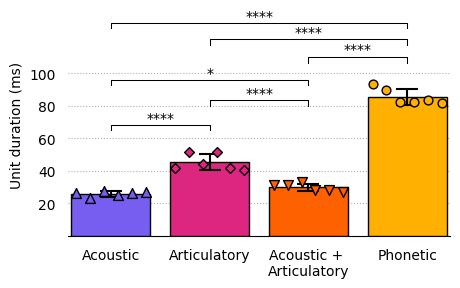

In [197]:
### import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
from scipy.stats import ttest_ind

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 10, 'legend.handleheight':1, 'hatch.linewidth': 2.0,
                           'lines.markersize':5, 'lines.linewidth':.75})

cm = 1/2.54
fig, ax = plt.subplots(1, 1, figsize=(11.4*cm,7.04*cm), constrained_layout=True)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
colors = ['grey']*4
colors = ['#785EF0', '#DC267F', '#FE6100', '#FFB000']
position = 0
h = 10*np.mean(quantizer_durations['cepstrum'])
yerr = 10*np.std(quantizer_durations['cepstrum'], ddof=1)
ax.bar(height=h, yerr=yerr, x=[position], color=colors[position],
       error_kw=dict(lw=1.5, capsize=8, capthick=1.5), edgecolor='black',zorder=3)
jittered_x = position +  np.linspace(-.35, .35, num=len(quantizer_durations['cepstrum']))
ax.scatter(jittered_x, 10*np.asarray(quantizer_durations['cepstrum']), 
           zorder=10, s=50, marker='^', edgecolor='black', color=colors[position])

position = 1
h = 10*np.mean(quantizer_durations['art_params'])
yerr = 10*np.std(quantizer_durations['art_params'], ddof=1)
ax.bar(height=h, yerr=yerr, x=[position], color=colors[position],
       error_kw=dict(lw=1.5, capsize=8, capthick=1.5), edgecolor='black',zorder=3)

jittered_x = position +  np.linspace(-.35, .35, num=len(quantizer_durations['art_params']))
ax.scatter(jittered_x, 10*np.asarray(quantizer_durations['art_params']), 
           zorder=10, marker='D', edgecolor='black', color=colors[position])

position = 2
h = 10*np.mean(quantizer_durations['cepstrum_art_params'])
yerr = 10*np.std(quantizer_durations['cepstrum_art_params'], ddof=1)
ax.bar(height=h, yerr=yerr, x=[position], color=colors[position],
       error_kw=dict(lw=1.5, capsize=8, capthick=1.5), edgecolor='black',zorder=3)
jittered_x = position +  np.linspace(-.35, .35, num=len(quantizer_durations['cepstrum_art_params']))
ax.scatter(jittered_x, 10*np.asarray(quantizer_durations['cepstrum_art_params']), 
           zorder=10, s=50, marker='v', edgecolor='black', color=colors[position])



position = 3
h = 10*np.mean(quantizer_durations['phone'])
yerr = 10*np.std(quantizer_durations['phone'], ddof=1)
ax.bar(height=h, yerr=yerr, x=[position], color=colors[position],
       error_kw=dict(lw=1.5, capsize=8, capthick=1.5), edgecolor='black',zorder=3)

jittered_x = position +  np.linspace(-.35, .35, num=len(quantizer_durations['phone']))
ax.scatter(jittered_x, 10*np.asarray(quantizer_durations['phone']), 
           zorder=10, s=40, marker='o', edgecolor='black', color=colors[position])

xticks = [0, 1, 2, 3]
ax.set_xticks(xticks)
ax.set_xticklabels(['Acoustic', 'Articulatory', 'Acoustic + \nArticulatory', 'Phonetic'])
ax.set_ylabel("Unit duration (ms)")

ax.grid(visible=True, axis='y', linestyle=':',zorder=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.margins(x=0.01)
ax.tick_params(left = False, bottom=False, pad=5)
ax.set_yticks([20,40,60,80,100])

# Statistical T-tests
quantizer_durations['cepstrum'] = np.asarray(quantizer_durations['cepstrum'])
quantizer_durations['art_params'] = np.asarray(quantizer_durations['art_params'])
quantizer_durations['cepstrum_art_params'] = np.asarray(quantizer_durations['cepstrum_art_params'])
quantizer_durations['phone'] = np.asarray(quantizer_durations['phone'])

logits_acoustic = np.log(quantizer_durations['cepstrum']/100 / (1 - quantizer_durations['cepstrum']/100))
logits_articulatory = np.log(quantizer_durations['art_params']/100 / (1 - quantizer_durations['art_params']/100))
logits_fusion = np.log(quantizer_durations['cepstrum_art_params']/100 / (1 - quantizer_durations['cepstrum_art_params']/100))
logits_phonetic = np.log(quantizer_durations['phone']/100 / (1 - quantizer_durations['phone']/100))

# acoustic vs everything
stat, p_value_acoustic_vs_articulatory = ttest_ind(logits_acoustic, logits_articulatory)
stat, p_value_acoustic_vs_fusion = ttest_ind(logits_acoustic, logits_fusion)
stat, p_value_acoustic_vs_phone = ttest_ind(logits_acoustic, logits_phonetic)

# articulatory vs everything
stat, p_value_articulatory_vs_fusion = ttest_ind(logits_articulatory, logits_fusion)
stat, p_value_articulatory_vs_phonetic = ttest_ind(logits_articulatory, logits_phonetic)

# fusion vs everything
stat, p_value_fusion_vs_phonetic = ttest_ind(logits_fusion, logits_phonetic)

def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)
    
ind = np.arange(4)
print(10*[np.mean(quantizer_durations['cepstrum']), np.mean(quantizer_durations['art_params']), 
                 np.mean(quantizer_durations['cepstrum_art_params']), np.mean(quantizer_durations['phone'])])


barplot_annotate_brackets(0, 1, p_value_acoustic_vs_articulatory, ind,
                [10*np.mean(quantizer_durations['cepstrum']), 10*np.mean(quantizer_durations['art_params']), 
                 10*np.mean(quantizer_durations['cepstrum_art_params']), 10*np.mean(quantizer_durations['phone'])], 
                barh=0.03, dh=0.2, maxasterix=4)
barplot_annotate_brackets(0, 2, p_value_acoustic_vs_fusion, ind,
                [10*np.mean(quantizer_durations['cepstrum']), 10*np.mean(quantizer_durations['art_params']), 
                 10*np.mean(quantizer_durations['cepstrum_art_params']), 10*np.mean(quantizer_durations['phone'])], 
                barh=0.03, dh=0.64, maxasterix=4)
barplot_annotate_brackets(0, 3, p_value_acoustic_vs_phone, ind,
                [10*np.mean(quantizer_durations['cepstrum']), 10*np.mean(quantizer_durations['art_params']), 
                 10*np.mean(quantizer_durations['cepstrum_art_params']), 10*np.mean(quantizer_durations['phone'])], 
                barh=0.03, dh=0.42, maxasterix=4)

barplot_annotate_brackets(1, 2, p_value_articulatory_vs_fusion, ind,
                [10*np.mean(quantizer_durations['cepstrum']), 10*np.mean(quantizer_durations['art_params']), 
                 10*np.mean(quantizer_durations['cepstrum_art_params']), 10*np.mean(quantizer_durations['phone'])], 
                barh=0.03, dh=0.25, maxasterix=4)
barplot_annotate_brackets(1, 3, p_value_articulatory_vs_phonetic, ind,
                [10*np.mean(quantizer_durations['cepstrum']), 10*np.mean(quantizer_durations['art_params']), 
                 10*np.mean(quantizer_durations['cepstrum_art_params']), 10*np.mean(quantizer_durations['phone'])], 
                barh=0.03, dh=0.23, maxasterix=4)

barplot_annotate_brackets(2, 3, p_value_fusion_vs_phonetic, ind,
                [10*np.mean(quantizer_durations['cepstrum']), 10*np.mean(quantizer_durations['art_params']), 
                 10*np.mean(quantizer_durations['cepstrum_art_params']), 10*np.mean(quantizer_durations['phone'])], 
                barh=0.03, dh=0.15, maxasterix=4)
plt.savefig('/home/engaclew/agent/out/quantizer/unit_durations.png', dpi=300)
plt.show()

In [146]:
from sklearn import metrics

SILENCE_NAMES = ["__", "sil"]

quantizer_stats = {}
for quantizer_path in tqdm(quantizer_paths):
    # Get features of test set
    quantizer = Quantizer.reload(str(quantizer_path))
    main_dataset = quantizer.main_dataset
    quantizer_lab = quantizer.get_datasplit_lab(2)
    quantizer_features = quantizer.autoencode_datasplit(2)
    quantizer_features = quantizer.autoencode_datasplit(2, cut_silences=True)
    quantizer_features = [{k:np.argmax(v, axis=1)} for k,v in quantizer_features[main_dataset.name]['quantized_index'].items()]
    
    # Create one-hot encoded phone stream
    dataset_name = quantizer.config["dataset"]["names"][0]
    transcriptions = main_dataset._get_items_lab()
    vowels = main_dataset.phones_infos['vowels']
    consonants = main_dataset.phones_infos['consonants']
    phones = vowels+consonants+['ER1', 'OW2', 'AW2', 'spn', 'ER2', 'AW0', 'breath',
                               'eir', '__', 'sil']
    one_hot_encoder = {k:i for i,k in enumerate(phones)}
    phones = {}
    for filename in transcriptions:
        transcription = transcriptions[filename]
        phonetic_features = []
        for idx, utterance in enumerate(transcription):
            start = utterance['start']
            end = utterance['end']
            name = utterance['name']
            if (name in SILENCE_NAMES) and (idx == 0 or idx == len(transcription)-1):
                continue
            phonetic_features += [one_hot_encoder[name]]*(end-start)
            phones[filename] = phonetic_features
    
    # Compute perplexity
    feats = []
    phone_feats = []
    for quantizer_feature in quantizer_features:
        for filename, feat in quantizer_feature.items():
            phone_feat = phones[filename]
            
            len_diff = len(feat) - len(phone_feat)
            # Cut to make sure phone and feat have same size
            left = np.abs(len_diff//2)
            right = left
            if len_diff % 2 == 1:
                right += 1
            if len_diff >= 0:
                feat = feat[left:len(feat)-right]
            else:
                phone_feat = phone_feat[left:len(phone_feat)-right]
            
            assert len(feat) == len(phone_feat)
            
            feats = np.concatenate([feats, feat])
            phone_feats = np.concatenate([phone_feats, phone_feat])
    
    def entropy(Y):
        unique, count = np.unique(Y, return_counts=True, axis=0)
        prob = count/len(Y)
        en = np.sum((-1)*prob*np.log2(prob))
        return en
    
    def joint_entropy(Y,X):
        YX = np.c_[Y,X]
        return entropy(YX)
    
    def cond_entropy(Y,X):
        return joint_entropy(Y, X) - entropy(X)
    
    def gain(Y, X):
        return entropy(Y) - cond_entropy(Y,X)

    def mutual_information(Y, X):
        return joint_entropy(Y,X) - cond_entropy(Y,X) - cond_entropy(X,Y)
    
    def pnmi(Y,X):
        return 1 - cond_entropy(Y,X)/entropy(Y)
    
    def cluster_purity(feats, phone_feats):
        contingency_matrix = metrics.cluster.contingency_matrix(phone_feats, feats)
        return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)
    
    def phone_purity(feats, phone_feats):
        contingency_matrix = metrics.cluster.contingency_matrix(feats, phone_feats)
        return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)
    
    phone2unit = np.power(2, cond_entropy(feats, phone_feats))
    unit2phone = np.power(2, cond_entropy(phone_feats, feats))
    ig = gain(feats, phone_feats)
    mutual_info = mutual_information(feats, phone_feats)
    pnmi_value = pnmi(phone_feats, feats)
    cp = cluster_purity(feats, phone_feats)
    pp = phone_purity(feats, phone_feats)
    
    metric_values = {'phone2unit': phone2unit, 'unit2phone': unit2phone, 'ig': ig,
                    'mutual_info': mutual_info, 'pnmi': pnmi_value, 
                     'cluster_purity': cp, 'phone_purity': pp}
    data_type_name = '_'.join(quantizer.config["dataset"]["data_types"]) 
    if data_type_name not in quantizer_stats:
        quantizer_stats[data_type_name] = {'phone2unit': [], 'unit2phone': [], 'ig': [], 
                                           'mutual_info': [], 'pnmi': [],
                                          'cluster_purity': [], 'phone_purity': []}
    for metric in ['phone2unit', 'unit2phone', 'ig', 'mutual_info', 'pnmi', 'cluster_purity', 'phone_purity']:
        quantizer_stats[data_type_name][metric].append(metric_values[metric])
        
    # Dirty hack to compute phone/phone metrics
    # works only if we have 1 architecture, otherwise will compute the same thing twice
    if data_type_name == "art_params":
        phone2unit = np.power(2, cond_entropy(phone_feats, phone_feats))
        unit2phone = np.power(2, cond_entropy(phone_feats, phone_feats))
        ig = gain(phone_feats, phone_feats)
        mutual_info = mutual_information(phone_feats, phone_feats)
        pnmi_value = pnmi(phone_feats, phone_feats)
        cp = cluster_purity(phone_feats, phone_feats)
        pp = cp
        metric_values = {'phone2unit': phone2unit, 'unit2phone': unit2phone, 'ig': ig,
                         'mutual_info': mutual_info, 'pnmi': pnmi_value, 'cluster_purity': cp,
                         'phone_purity': pp}
        if 'phone' not in quantizer_stats:
            quantizer_stats['phone'] = {'phone2unit': [], 'unit2phone': [], 'ig': [], 'mutual_info': [],
                                       'pnmi': [], 'cluster_purity': [], 'phone_purity': []}
        for metric in ['phone2unit', 'unit2phone', 'ig', 'mutual_info', 'pnmi', 'cluster_purity', 'phone_purity']:
            quantizer_stats['phone'][metric].append(metric_values[metric])

  0%|          | 0/18 [00:00<?, ?it/s]

/home/engaclew/miniconda3/envs/agent/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 1.3.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/home/engaclew/miniconda3/envs/agent/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 1.3.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/home/engaclew/miniconda3/envs/agent/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 1.3.2 when using version 1

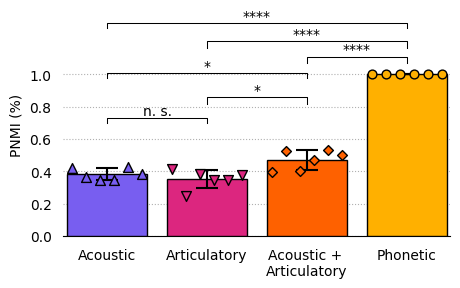

In [179]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import matplotlib
import numpy as np
from collections import OrderedDict

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 10, 'legend.handleheight':1, 'hatch.linewidth': 1.0,
                           'lines.markersize':5, 'lines.linewidth':.75})

cm = 1/2.54
fig, ax = plt.subplots(1, 1, figsize=(11.4*cm,7.04*cm), constrained_layout=True)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
colors = ['grey']*4
colors = ['#785EF0', '#DC267F', '#FE6100', '#FFB000']

position = 0
h = np.mean(quantizer_stats['cepstrum']['pnmi'])
yerr = np.std(quantizer_stats['cepstrum']['pnmi'], ddof=1)
ax.bar(height=h, yerr=yerr, x=[position], color=colors[position],
       error_kw=dict(lw=1.5, capsize=8, capthick=1.5), edgecolor='black',zorder=3)
jittered_x = position +  np.linspace(-.35, .35, num=len(quantizer_stats['cepstrum']['pnmi']))
ax.scatter(jittered_x, np.asarray(quantizer_stats['cepstrum']['pnmi']), 
           zorder=10, s=50, marker='^', edgecolor='black', color=colors[position])

position = 1
h = np.mean(quantizer_stats['art_params']['pnmi'])
yerr = np.std(quantizer_stats['art_params']['pnmi'], ddof=1)
ax.bar(height=h, yerr=yerr, x=[position], color=colors[position],
       error_kw=dict(lw=1.5, capsize=8, capthick=1.5), edgecolor='black',zorder=3)

jittered_x = position +  np.linspace(-.35, .35, num=len(quantizer_stats['art_params']['pnmi']))
ax.scatter(jittered_x, np.asarray(quantizer_stats['art_params']['pnmi']), 
           zorder=10, s=50, marker='v', edgecolor='black', color=colors[position])

position = 2
h = np.mean(quantizer_stats['cepstrum_art_params']['pnmi'])
yerr = np.std(quantizer_stats['cepstrum_art_params']['pnmi'], ddof=1)
ax.bar(height=h, yerr=yerr, x=[position], color=colors[position],
       error_kw=dict(lw=1.5, capsize=8, capthick=1.5), edgecolor='black',zorder=3)
jittered_x = position +  np.linspace(-.35, .35, num=len(quantizer_stats['cepstrum_art_params']['pnmi']))
ax.scatter(jittered_x, np.asarray(quantizer_stats['cepstrum_art_params']['pnmi']), 
           zorder=10, marker='D', edgecolor='black', color=colors[position])

position = 3
h = np.mean(quantizer_stats['phone']['pnmi'])
yerr = np.std(quantizer_stats['phone']['pnmi'], ddof=1)
ax.bar(height=h, yerr=yerr, x=[position], color=colors[position],
       error_kw=dict(lw=1.5, capsize=8, capthick=1.5), edgecolor='black',zorder=3)

jittered_x = position +  np.linspace(-.35, .35, num=len(quantizer_stats['phone']['pnmi']))
ax.scatter(jittered_x, np.asarray(quantizer_stats['phone']['pnmi']), 
           zorder=10, s=40, marker='o', edgecolor='black', color=colors[position])

xticks = [0, 1, 2, 3]
ax.set_xticks(xticks)
ax.set_xticklabels(['Acoustic', 'Articulatory', 'Acoustic + \nArticulatory', 'Phonetic'])
ax.set_ylabel("PNMI (%)")
ax.grid(visible=True, axis='y', linestyle=':',zorder=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.margins(x=0.01)
ax.tick_params(left = False, bottom=False, pad=5)

# Statistical T-tests
quantizer_stats['cepstrum']['pnmi'] = np.asarray(quantizer_stats['cepstrum']['pnmi'])
quantizer_stats['art_params']['pnmi'] = np.asarray(quantizer_stats['art_params']['pnmi'])
quantizer_stats['cepstrum_art_params']['pnmi'] = np.asarray(quantizer_stats['cepstrum_art_params']['pnmi'])
quantizer_stats['phone']['pnmi'] = np.asarray(quantizer_stats['phone']['pnmi'])

logits_acoustic = np.log(quantizer_stats['cepstrum']['pnmi']/100 / (1 - quantizer_stats['cepstrum']['pnmi']/100))
logits_articulatory = np.log(quantizer_stats['art_params']['pnmi']/100 / (1 - quantizer_stats['art_params']['pnmi']/100))
logits_fusion = np.log(quantizer_stats['cepstrum_art_params']['pnmi']/100 / (1 - quantizer_stats['cepstrum_art_params']['pnmi']/100))
logits_phonetic = np.log(quantizer_stats['phone']['pnmi']/100 / (1 - quantizer_stats['phone']['pnmi']/100))

# acoustic vs everything
stat, p_value_acoustic_vs_articulatory = ttest_ind(logits_acoustic, logits_articulatory)
stat, p_value_acoustic_vs_fusion = ttest_ind(logits_acoustic, logits_fusion)
stat, p_value_acoustic_vs_phone = ttest_ind(logits_acoustic, logits_phonetic)

# articulatory vs everything
stat, p_value_articulatory_vs_fusion = ttest_ind(logits_articulatory, logits_fusion)
stat, p_value_articulatory_vs_phonetic = ttest_ind(logits_articulatory, logits_phonetic)

# fusion vs everything
stat, p_value_fusion_vs_phonetic = ttest_ind(logits_fusion, logits_phonetic)

barplot_annotate_brackets(0, 1, p_value_acoustic_vs_articulatory, ind,
                [np.mean(quantizer_stats['cepstrum']['pnmi']), np.mean(quantizer_stats['art_params']['pnmi']), 
                 np.mean(quantizer_stats['cepstrum_art_params']['pnmi']), np.mean(quantizer_stats['phone']['pnmi'])], 
                barh=0.03, dh=0.3, maxasterix=4)
barplot_annotate_brackets(0, 2, p_value_acoustic_vs_fusion, ind,
                [np.mean(quantizer_stats['cepstrum']['pnmi']), np.mean(quantizer_stats['art_params']['pnmi']), 
                 np.mean(quantizer_stats['cepstrum_art_params']['pnmi']), np.mean(quantizer_stats['phone']['pnmi'])], 
                barh=0.03, dh=0.48, maxasterix=4)
barplot_annotate_brackets(0, 3, p_value_acoustic_vs_phone, ind,
                [np.mean(quantizer_stats['cepstrum']['pnmi']), np.mean(quantizer_stats['art_params']['pnmi']), 
                 np.mean(quantizer_stats['cepstrum_art_params']['pnmi']), np.mean(quantizer_stats['phone']['pnmi'])], 
                barh=0.03, dh=0.27, maxasterix=4)

barplot_annotate_brackets(1, 2, p_value_articulatory_vs_fusion, ind,
                [np.mean(quantizer_stats['cepstrum']['pnmi']), np.mean(quantizer_stats['art_params']['pnmi']), 
                 np.mean(quantizer_stats['cepstrum_art_params']['pnmi']), np.mean(quantizer_stats['phone']['pnmi'])], 
                barh=0.03, dh=0.25, maxasterix=4)
barplot_annotate_brackets(1, 3, p_value_articulatory_vs_phonetic, ind,
                [np.mean(quantizer_stats['cepstrum']['pnmi']), np.mean(quantizer_stats['art_params']['pnmi']), 
                 np.mean(quantizer_stats['cepstrum_art_params']['pnmi']), np.mean(quantizer_stats['phone']['pnmi'])], 
                barh=0.03, dh=0.12, maxasterix=4)

barplot_annotate_brackets(2, 3, p_value_fusion_vs_phonetic, ind,
                [np.mean(quantizer_stats['cepstrum']['pnmi']), np.mean(quantizer_stats['art_params']['pnmi']), 
                 np.mean(quantizer_stats['cepstrum_art_params']['pnmi']), np.mean(quantizer_stats['phone']['pnmi'])], 
                barh=0.03, dh=0.05, maxasterix=4)
ax.set_yticks([0, .2, .4, .6, .8, 1])

plt.savefig('/home/engaclew/agent/out/quantizer/pnmi.png', dpi=300)
plt.show()

25.862956336616282
45.338340214095034
29.899061065662394
85.6404569638944
0.38257074277714126
0.35277037696651964
0.4709493692363937
1.0


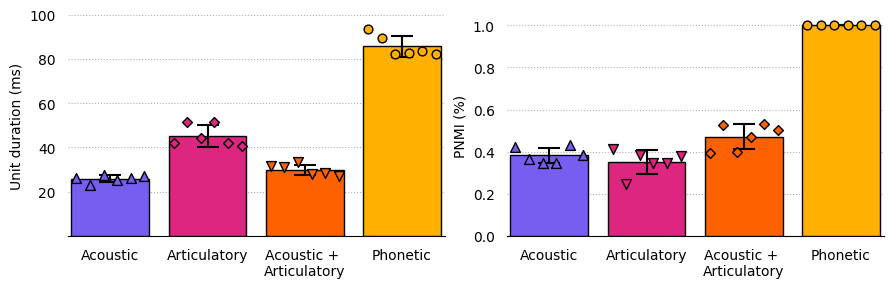

In [45]:
### import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 10, 'legend.handleheight':1, 'hatch.linewidth': 2.0,
                           'lines.markersize':5, 'lines.linewidth':.75})

cm = 1/2.54
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22.4*cm,7.04*cm), constrained_layout=True)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
colors = ['grey']*4
colors = ['#785EF0', '#DC267F', '#FE6100', '#FFB000']
position = 0
h = 10*np.mean(quantizer_durations['cepstrum'])
print(h)
yerr = 10*np.std(quantizer_durations['cepstrum'], ddof=1)
ax1.bar(height=h, yerr=yerr, x=[position], color=colors[position],
       error_kw=dict(lw=1.5, capsize=8, capthick=1.5), edgecolor='black',zorder=3)
jittered_x = position +  np.linspace(-.35, .35, num=len(quantizer_durations['cepstrum']))
ax1.scatter(jittered_x, 10*np.asarray(quantizer_durations['cepstrum']), 
           zorder=10, s=50, marker='^', edgecolor='black', color=colors[position])

position = 1
h = 10*np.mean(quantizer_durations['art_params'])
print(h)
yerr = 10*np.std(quantizer_durations['art_params'], ddof=1)
ax1.bar(height=h, yerr=yerr, x=[position], color=colors[position],
       error_kw=dict(lw=1.5, capsize=8, capthick=1.5), edgecolor='black',zorder=3)

jittered_x = position +  np.linspace(-.35, .35, num=len(quantizer_durations['art_params']))
ax1.scatter(jittered_x, 10*np.asarray(quantizer_durations['art_params']), 
           zorder=10, marker='D', edgecolor='black', color=colors[position])

position = 2
h = 10*np.mean(quantizer_durations['cepstrum_art_params'])
print(h)
yerr = 10*np.std(quantizer_durations['cepstrum_art_params'], ddof=1)
ax1.bar(height=h, yerr=yerr, x=[position], color=colors[position],
       error_kw=dict(lw=1.5, capsize=8, capthick=1.5), edgecolor='black',zorder=3)
jittered_x = position +  np.linspace(-.35, .35, num=len(quantizer_durations['cepstrum_art_params']))
ax1.scatter(jittered_x, 10*np.asarray(quantizer_durations['cepstrum_art_params']), 
           zorder=10, s=50, marker='v', edgecolor='black', color=colors[position])



position = 3
h = 10*np.mean(quantizer_durations['phone'])
print(h)
yerr = 10*np.std(quantizer_durations['phone'], ddof=1)
ax1.bar(height=h, yerr=yerr, x=[position], color=colors[position],
       error_kw=dict(lw=1.5, capsize=8, capthick=1.5), edgecolor='black',zorder=3)

jittered_x = position +  np.linspace(-.35, .35, num=len(quantizer_durations['phone']))
ax1.scatter(jittered_x, 10*np.asarray(quantizer_durations['phone']), 
           zorder=10, s=40, marker='o', edgecolor='black', color=colors[position])

xticks = [0, 1, 2, 3]
ax1.set_xticks(xticks)
ax1.set_xticklabels(['Acoustic', 'Articulatory', 'Acoustic + \nArticulatory', 'Phonetic'])
ax1.set_ylabel("Unit duration (ms)")

ax1.grid(visible=True, axis='y', linestyle=':',zorder=0)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.margins(x=0.01)
ax1.tick_params(left = False, bottom=False, pad=5)
ax1.set_yticks([20,40,60,80,100])
plt.savefig('/home/engaclew/agent/out/quantizer/unit_durations.png', dpi=300)


position = 0
h = np.mean(quantizer_stats['cepstrum']['pnmi'])
print(h)
yerr = np.std(quantizer_stats['cepstrum']['pnmi'], ddof=1)
ax2.bar(height=h, yerr=yerr, x=[position], color=colors[position],
       error_kw=dict(lw=1.5, capsize=8, capthick=1.5), edgecolor='black',zorder=3)
jittered_x = position +  np.linspace(-.35, .35, num=len(quantizer_stats['cepstrum']['pnmi']))
ax2.scatter(jittered_x, np.asarray(quantizer_stats['cepstrum']['pnmi']), 
           zorder=10, s=50, marker='^', edgecolor='black', color=colors[position])

position = 1
h = np.mean(quantizer_stats['art_params']['pnmi'])
print(h)
yerr = np.std(quantizer_stats['art_params']['pnmi'], ddof=1)
ax2.bar(height=h, yerr=yerr, x=[position], color=colors[position],
       error_kw=dict(lw=1.5, capsize=8, capthick=1.5), edgecolor='black',zorder=3)

jittered_x = position +  np.linspace(-.35, .35, num=len(quantizer_stats['art_params']['pnmi']))
ax2.scatter(jittered_x, np.asarray(quantizer_stats['art_params']['pnmi']), 
           zorder=10, s=50, marker='v', edgecolor='black', color=colors[position])

position = 2
h = np.mean(quantizer_stats['cepstrum_art_params']['pnmi'])
print(h)
yerr = np.std(quantizer_stats['cepstrum_art_params']['pnmi'], ddof=1)
ax2.bar(height=h, yerr=yerr, x=[position], color=colors[position],
       error_kw=dict(lw=1.5, capsize=8, capthick=1.5), edgecolor='black',zorder=3)
jittered_x = position +  np.linspace(-.35, .35, num=len(quantizer_stats['cepstrum_art_params']['pnmi']))
ax2.scatter(jittered_x, np.asarray(quantizer_stats['cepstrum_art_params']['pnmi']), 
           zorder=10, marker='D', edgecolor='black', color=colors[position])

position = 3
h = np.mean(quantizer_stats['phone']['pnmi'])
print(h)
yerr = np.std(quantizer_stats['phone']['pnmi'], ddof=1)
ax2.bar(height=h, yerr=yerr, x=[position], color=colors[position],
       error_kw=dict(lw=1.5, capsize=8, capthick=1.5), edgecolor='black',zorder=3)

jittered_x = position +  np.linspace(-.35, .35, num=len(quantizer_stats['phone']['pnmi']))
ax2.scatter(jittered_x, np.asarray(quantizer_stats['phone']['pnmi']), 
           zorder=10, s=40, marker='o', edgecolor='black', color=colors[position])

xticks = [0, 1, 2, 3]
ax2.set_xticks(xticks)
ax2.set_xticklabels(['Acoustic', 'Articulatory', 'Acoustic + \nArticulatory', 'Phonetic'])
ax2.set_ylabel("PNMI (%)")
ax2.grid(visible=True, axis='y', linestyle=':',zorder=0)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.margins(x=0.01)
ax2.tick_params(left = False, bottom=False, pad=5)
plt.savefig('/home/engaclew/Downloads/duration_pnmi.png', dpi=300)

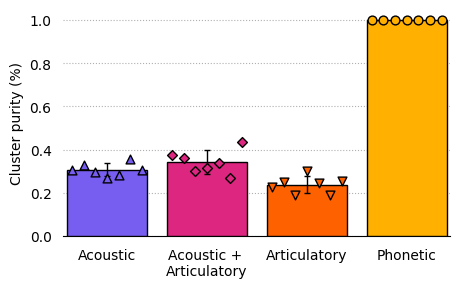

In [95]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import matplotlib
import numpy as np
from collections import OrderedDict

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 10, 'legend.handleheight':1, 'hatch.linewidth': 1.0,
                           'lines.markersize':5, 'lines.linewidth':.75})

cm = 1/2.54
fig, ax = plt.subplots(1, 1, figsize=(11.4*cm,7.04*cm), constrained_layout=True)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
colors = ['grey']*4
colors = ['#785EF0', '#DC267F', '#FE6100', '#FFB000']

position = 0
h = np.mean(quantizer_stats['cepstrum']['cluster_purity'])
yerr = np.std(quantizer_stats['cepstrum']['cluster_purity'], ddof=1)
ax.bar(height=h, yerr=yerr, x=[position], color=colors[position],
       error_kw=dict(lw=1, capsize=2, capthick=1), edgecolor='black',zorder=3)
jittered_x = position +  np.linspace(-.35, .35, num=len(quantizer_stats['cepstrum']['cluster_purity']))
ax.scatter(jittered_x, np.asarray(quantizer_stats['cepstrum']['cluster_purity']), 
           zorder=10, s=40, marker='^', edgecolor='black', color=colors[position])

position = 1
h = np.mean(quantizer_stats['cepstrum_art_params']['cluster_purity'])
yerr = np.std(quantizer_stats['cepstrum_art_params']['cluster_purity'], ddof=1)
ax.bar(height=h, yerr=yerr, x=[position], color=colors[position],
       error_kw=dict(lw=1, capsize=2, capthick=1), edgecolor='black',zorder=3)
jittered_x = position +  np.linspace(-.35, .35, num=len(quantizer_stats['cepstrum_art_params']['cluster_purity']))
ax.scatter(jittered_x, np.asarray(quantizer_stats['cepstrum_art_params']['cluster_purity']), 
           zorder=10, marker='D', edgecolor='black', color=colors[position])

position = 2
h = np.mean(quantizer_stats['art_params']['cluster_purity'])
yerr = np.std(quantizer_stats['art_params']['cluster_purity'], ddof=1)
ax.bar(height=h, yerr=yerr, x=[position], color=colors[position],
       error_kw=dict(lw=1, capsize=2, capthick=1), edgecolor='black',zorder=3)

jittered_x = position +  np.linspace(-.35, .35, num=len(quantizer_stats['art_params']['cluster_purity']))
ax.scatter(jittered_x, np.asarray(quantizer_stats['art_params']['cluster_purity']), 
           zorder=10, s=40, marker='v', edgecolor='black', color=colors[position])

position = 3
h = np.mean(quantizer_stats['phone']['cluster_purity'])
yerr = np.std(quantizer_stats['phone']['cluster_purity'], ddof=1)
ax.bar(height=h, yerr=yerr, x=[position], color=colors[position],
       error_kw=dict(lw=1, capsize=2, capthick=1), edgecolor='black',zorder=3)

jittered_x = position +  np.linspace(-.35, .35, num=len(quantizer_stats['phone']['cluster_purity']))
ax.scatter(jittered_x, np.asarray(quantizer_stats['phone']['cluster_purity']), 
           zorder=10, s=40, marker='o', edgecolor='black', color=colors[position])

xticks = [0, 1, 2, 3]
ax.set_xticks(xticks)
ax.set_xticklabels(['Acoustic', 'Acoustic + \nArticulatory', 'Articulatory', 'Phonetic'])
ax.set_ylabel("Cluster purity (%)")
ax.grid(visible=True, axis='y', linestyle=':',zorder=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.margins(x=0.01)
ax.tick_params(left = False, bottom=False, pad=5)
plt.savefig('/home/engaclew/agent/out/quantizer/cluster_purity.png', dpi=300)

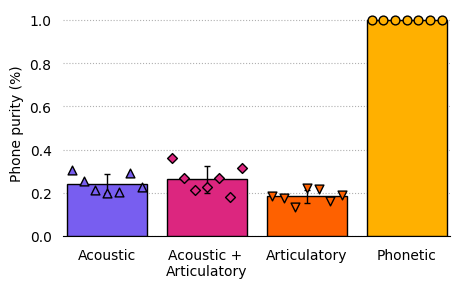

In [96]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import matplotlib
import numpy as np
from collections import OrderedDict

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 10, 'legend.handleheight':1, 'hatch.linewidth': 1.0,
                           'lines.markersize':5, 'lines.linewidth':.75})

cm = 1/2.54
fig, ax = plt.subplots(1, 1, figsize=(11.4*cm,7.04*cm), constrained_layout=True)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
colors = ['grey']*4
colors = ['#785EF0', '#DC267F', '#FE6100', '#FFB000']

position = 0
h = np.mean(quantizer_stats['cepstrum']['phone_purity'])
yerr = np.std(quantizer_stats['cepstrum']['phone_purity'], ddof=1)
ax.bar(height=h, yerr=yerr, x=[position], color=colors[position],
       error_kw=dict(lw=1, capsize=2, capthick=1), edgecolor='black',zorder=3)
jittered_x = position +  np.linspace(-.35, .35, num=len(quantizer_stats['cepstrum']['phone_purity']))
ax.scatter(jittered_x, np.asarray(quantizer_stats['cepstrum']['phone_purity']), 
           zorder=10, s=40, marker='^', edgecolor='black', color=colors[position])

position = 1
h = np.mean(quantizer_stats['cepstrum_art_params']['phone_purity'])
yerr = np.std(quantizer_stats['cepstrum_art_params']['phone_purity'], ddof=1)
ax.bar(height=h, yerr=yerr, x=[position], color=colors[position],
       error_kw=dict(lw=1, capsize=2, capthick=1), edgecolor='black',zorder=3)
jittered_x = position +  np.linspace(-.35, .35, num=len(quantizer_stats['cepstrum_art_params']['phone_purity']))
ax.scatter(jittered_x, np.asarray(quantizer_stats['cepstrum_art_params']['phone_purity']), 
           zorder=10, marker='D', edgecolor='black', color=colors[position])

position = 2
h = np.mean(quantizer_stats['art_params']['phone_purity'])
yerr = np.std(quantizer_stats['art_params']['phone_purity'], ddof=1)
ax.bar(height=h, yerr=yerr, x=[position], color=colors[position],
       error_kw=dict(lw=1, capsize=2, capthick=1), edgecolor='black',zorder=3)

jittered_x = position +  np.linspace(-.35, .35, num=len(quantizer_stats['art_params']['phone_purity']))
ax.scatter(jittered_x, np.asarray(quantizer_stats['art_params']['phone_purity']), 
           zorder=10, s=40, marker='v', edgecolor='black', color=colors[position])

position = 3
h = np.mean(quantizer_stats['phone']['phone_purity'])
yerr = np.std(quantizer_stats['phone']['phone_purity'], ddof=1)
ax.bar(height=h, yerr=yerr, x=[position], color=colors[position],
       error_kw=dict(lw=1, capsize=2, capthick=1), edgecolor='black',zorder=3)

jittered_x = position +  np.linspace(-.35, .35, num=len(quantizer_stats['phone']['phone_purity']))
ax.scatter(jittered_x, np.asarray(quantizer_stats['phone']['phone_purity']), 
           zorder=10, s=40, marker='o', edgecolor='black', color=colors[position])

xticks = [0, 1, 2, 3]
ax.set_xticks(xticks)
ax.set_xticklabels(['Acoustic', 'Acoustic + \nArticulatory', 'Articulatory', 'Phonetic'])
ax.set_ylabel("Phone purity (%)")
ax.grid(visible=True, axis='y', linestyle=':',zorder=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.margins(x=0.01)
ax.tick_params(left = False, bottom=False, pad=5)
plt.savefig('/home/engaclew/agent/out/quantizer/phone_purity.png', dpi=300)